In [1]:
import pandas as pd
df = pd.read_csv('dataset_case_study.csv')

In [2]:
import numpy as np
df['creation_date'] = pd.to_datetime(df['creation_date'])
# Now calculate days since first creation
df['days_since_first'] = (df['creation_date'] - df['creation_date'].min()).dt.days
df.drop(columns='creation_date',inplace=True)

df['price_per_night']=df['price_euro']/(df['length_of_stay']+1)

df['credit_card_id_count'] = df.groupby('credit_card_id')['credit_card_id'].transform('count')
df['ip_id_count'] = df.groupby('ip_id')['ip_id'].transform('count')
df['email_id_count'] = df.groupby('email_id')['email_id'].transform('count')
df['hotel_id_count'] = df.groupby('hotel_id')['hotel_id'].transform('count')

lang_to_country = {
    'German': 'Germany',
    'Icelandic': 'Iceland', 
    'Slovak': 'Slovakia',
    'Spanish': 'Spain',
    'Norwegian': 'Norway',
    'Luxembourgish': 'Luxembourg',
    'Hungarian': 'Hungary',
    'Italian': 'Italy',
    'Danish': 'Denmark',
    'Swedish': 'Sweden',
    'French': 'France', 
    'Dutch': 'Netherlands',
    'Finnish': 'Finland',
    'Bulgarian': 'Bulgaria',
    'Maltese': 'Malta'}
df['language']=df['language'].map(lang_to_country)

df['language_flag1']=np.where(df['card_issuing_country']!=df['language'],1,0)
df['language_flag2']=np.where(df['card_issuing_country']!=df['booker_country'],1,0)
df['language_flag3']=np.where(df['language']!=df['booker_country'],1,0)

In [3]:
df_model=df.copy()
df_model.drop(columns=['price_euro','booker_country', 'card_issuing_country', 'hotel_country', 'language','transaction_id','ip_id','credit_card_id','hotel_id','email_id','days_since_first'],inplace=True)
df_model.head()

,book_window,length_of_stay,email_domain,auth_result,property_age,payment_method,price_per_night,credit_card_id_count,ip_id_count,email_id_count,hotel_id_count,language_flag1,language_flag2,language_flag3
0,89,5,@strawberry.com,AUTHORISED,30,mastercard,579.693333,1,1,1,3,0,0,0
1,30,13,@grapefruit.com,AUTHORISED,28,visa,176.927143,1,1,1,1,0,0,0
2,68,17,@grape.com,AUTHORISED,29,mastercard,158.614444,1,1,1,1,1,0,1
3,11,17,@blueberry.com,AUTHORISED,33,visa,210.017222,1,1,1,1,0,0,0
4,64,13,@lemon.com,AUTHORISED,27,paypal,151.080000,1,1,1,1,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [5]:
def plot_result(y_test, y_pred_prob):
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import matplotlib.pyplot as plt
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate (recall)')
    plt.title('ROC curve')
    plt.legend()
     
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    # Plot Precision-Recall curve
    plt.subplot(1,2,2)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()

In [6]:
categorical=['email_domain','payment_method','language_flag1','language_flag2','language_flag3']
numeric=['book_window','length_of_stay','property_age','price_per_night','ip_id_count','credit_card_id_count','email_id_count','hotel_id_count']

X=df_model.drop('auth_result',axis=1)

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric),('cat', OrdinalEncoder(), categorical)], remainder='drop')

# Fit preprocessor and transform data
X_transformed = preprocessor.fit_transform(X)

In [7]:
X.head()

,book_window,length_of_stay,email_domain,property_age,payment_method,price_per_night,credit_card_id_count,ip_id_count,email_id_count,hotel_id_count,language_flag1,language_flag2,language_flag3
0,89,5,@strawberry.com,30,mastercard,579.693333,1,1,1,3,0,0,0
1,30,13,@grapefruit.com,28,visa,176.927143,1,1,1,1,0,0,0
2,68,17,@grape.com,29,mastercard,158.614444,1,1,1,1,1,0,1
3,11,17,@blueberry.com,33,visa,210.017222,1,1,1,1,0,0,0
4,64,13,@lemon.com,27,paypal,151.080000,1,1,1,1,0,0,0


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y=df_model['auth_result'].map({'AUTHORISED':0, 'INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED':0, 'ERROR':0, 'FRAUD':1,'REFUSED':1})

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
a_name=[]
a_val=[]
for i in range(len(X.columns)):
    if X.iloc[:,i].dtype=='int64':
        anomaly_score=X.iloc[:,i]  
        
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        if roc_auc<0.5:
            anomaly_score=-anomaly_score
            
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        precision, recall, thresholds = precision_recall_curve(y,anomaly_score)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_index = np.argmax(f1_scores)
        best_f1 = f1_scores[best_index]
        best_precision = precision[best_index]
        best_recall = recall[best_index]
        avg_precision = average_precision_score(y,anomaly_score)
        
        a=[best_f1.item(),best_precision.item(),best_recall.item(),avg_precision,roc_auc]
        a_val.append(a)
        a_name.append(X.columns[i])


In [10]:
df_result=pd.DataFrame(a_val,columns=['f1-score','precision','recall','roc-auc','auc'],index=a_name) 
df_result=df_result.round(2).T
#df_result

In [11]:
def get_evaluation(y,anomaly_score):
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        if roc_auc<0.5:
            anomaly_score=-anomaly_score
            
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        precision, recall, thresholds = precision_recall_curve(y,anomaly_score)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_index = np.argmax(f1_scores)
        best_f1 = f1_scores[best_index]
        best_precision = precision[best_index]
        best_recall = recall[best_index]
        avg_precision = average_precision_score(y,anomaly_score)
        
        a=[best_f1.item(),best_precision.item(),best_recall.item(),avg_precision,roc_auc]
        return a

In [12]:
from sklearn.ensemble import IsolationForest
iso=IsolationForest(n_estimators=500, random_state=0)
iso.fit(X_transformed)
anomaly_score_iso=iso.decision_function(X_transformed)
a=get_evaluation(y,-anomaly_score_iso)
a

[0.4202505922256093,
 0.7849462365591398,
 0.2869364161849711,
 0.31508793000461444,
 0.6442738393206187]

In [13]:
df_result['isolation_forest']=a

In [14]:
df_result

,book_window,length_of_stay,property_age,credit_card_id_count,ip_id_count,email_id_count,hotel_id_count,language_flag1,language_flag2,language_flag3,isolation_forest
f1-score,0.38,0.27,0.43,0.43,0.38,0.42,0.42,0.18,0.23,0.23,0.420251
precision,0.54,0.25,0.84,0.84,0.53,0.77,0.77,0.12,0.17,0.17,0.784946
recall,0.29,0.28,0.29,0.29,0.29,0.29,0.29,0.41,0.35,0.36,0.286936
roc-auc,0.23,0.15,0.31,0.28,0.17,0.27,0.30,0.08,0.09,0.10,0.315088
auc,0.64,0.63,0.65,0.64,0.64,0.64,0.65,0.62,0.63,0.63,0.644274


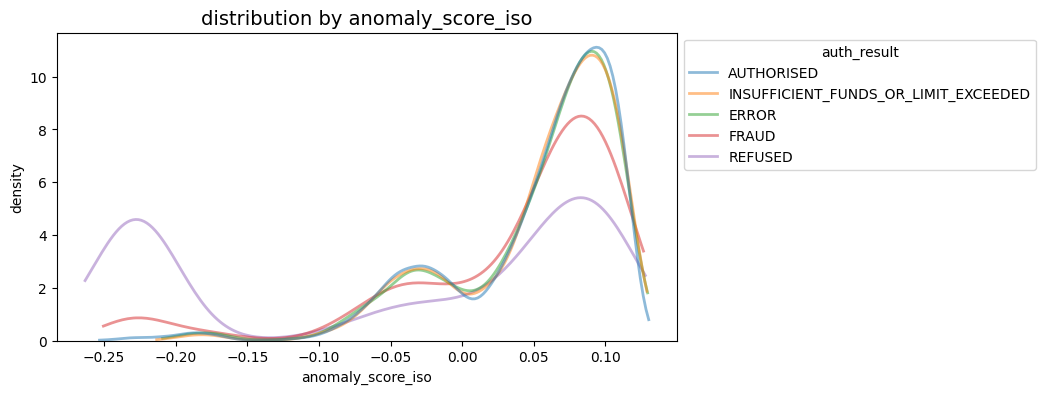

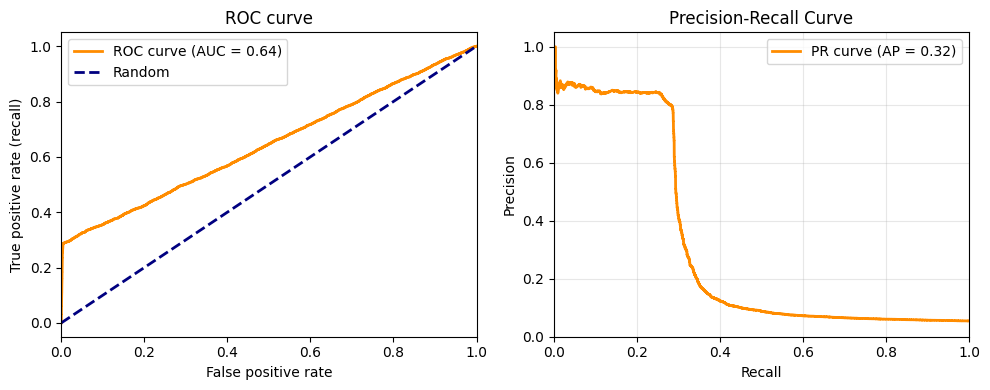

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
ax=sns.kdeplot( x=anomaly_score_iso, hue=df_model['auth_result'], alpha=0.5, linewidth=2, common_norm=False,cut=0)
plt.title('distribution by anomaly_score_iso', fontsize=14)
plt.xlabel('anomaly_score_iso')
plt.ylabel('density')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

plot_result(y,-anomaly_score_iso)

In [20]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination='auto')
y_pred_lof = lof.fit_predict(X_transformed)
anomaly_score_lof = lof.negative_outlier_factor_
a=get_evaluation(y,-anomaly_score_lof)
df_result['local_outlier_factor']=a
#plot_result(y, -anomaly_score_lof)

In [21]:
df_result.T.round(2)

,f1-score,precision,recall,roc-auc,auc
book_window,0.38,0.54,0.29,0.23,0.64
length_of_stay,0.27,0.25,0.28,0.15,0.63
property_age,0.43,0.84,0.29,0.31,0.65
credit_card_id_count,0.43,0.84,0.29,0.28,0.64
ip_id_count,0.38,0.53,0.29,0.17,0.64
email_id_count,0.42,0.77,0.29,0.27,0.64
hotel_id_count,0.42,0.77,0.29,0.30,0.65
language_flag1,0.18,0.12,0.41,0.08,0.62
language_flag2,0.23,0.17,0.35,0.09,0.63
language_flag3,0.23,0.17,0.36,0.10,0.63


Based on the business goal, we can select the appropriate evaluation metric and corresponding intervention strategy.

- Maximizing fraud detection:

If the goal is to identify as many fraudulent or suspicious transactions as possible and the majority of transactions are legitimate, we should prioritize recall. In this case, features like language_flag become particularly important. Any mismatch between (card_issuing_country, language), (card_issuing_country, booker_country), or (booker_country, language) should trigger a flag.

- Minimizing harm to legitimate customers:

If the cost of inconveniencing a genuine customer or disrupting a regular transaction is high, we should prioritize precision. Here, features such as property_age and credit_card_id_count are more relevant. For example, a frequently used credit card or a booking for a newly listed hotel may trigger an alert.

- Balancing both false positives and false negatives:

If both types of errors are costly, we should consider metrics like F1-score or ROC-AUC. In this scenario, ensemble learning methods such as Isolation Forest can help detect outliers, while features like property_age and credit_card_id_count remain important for risk assessment.

In [22]:
df_result.T.round(2).to_csv('result_unsupervised.csv')